#### CRM raw 2023 deal dataset exploration

A deal here represents a CRM entity for one-off product sale to a customer rather than a subscription sale. Deals follow a straightforward methodology, a new deal is created when new sales opportunity is identified and confirmed; any deal will be closed as won or lost over a period of time called the sales cycle.  

Deals are associated with customer accounts aka companies; this should be one (company) to (many) deals association. Few attributes of companies are present in the deal dataset. Deals are devided into first sale to a new customer and the repetead or 2nd+ sales; first deals are as well attributed to the particular sales channel recorded in the Deal_source variable. We presume that 1st deals are in 1-1 relationship to their customer companies, more exacttly each company having 1 (or 0) 1st deals and each first deal is associated with one and only one company.  

As the case with real life data there are number of inconsistencies and errors in the dataset, let it be discovered it we move on with the exploration. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# file2read = '/Users/andrew/Documents/2023 JUPYTER Notebook/swag42 notebooks/\
# data/hubspot-crm-exports-deals-all-pieplienes-export-v-20240131-(excl 2 Niall prop deals.csv'

file2read = 'data/2023 raw deal dataset_1.csv'

df = pd.read_csv(file2read) #, index_col = 'Record ID')

In [3]:
# df.columns
df.shape

(934, 14)

___Pre-processing___

In [4]:
#column names for conv
df.columns = df.columns.str.replace(' ', '_')

In [5]:
#convert dates column into date types
df[['Create_Date', 'Close_Date']] = df[['Create_Date', 'Close_Date']]\
                                     .apply(pd.to_datetime)

In [5]:
#df.head()
#df.info()

#checking for nulls
df.isnull().sum()

Record_ID                         0
Deal_Name                         0
Deal_Stage                        0
Close_Date                        0
Associated_Company                0
int_Related_company_HC            2
int_Related_company_Industry    177
Pipeline                          0
Amount_in_company_currency        0
Create_Date                       0
Deal_source                       0
Associated_Company_IDs            0
Associated_Contact_IDs            4
Deal_owner                        5
dtype: int64

In [8]:
#split ID's stirngs into lists with dtype = string
df['Split_Associated_Contact_IDs'] = df.Associated_Contact_IDs.str.split(";")
df['Split_Associated_Company_IDs'] = df.Associated_Company_IDs.str.split(";")

In [9]:
#check where a deal is associated with 1+ companies which in fact is an incosistency 
# df[ df.Split_Associated_Company_IDs.apply(lambda x: len(x)) > 1]

In [10]:
#for simplicity get the first company ID into the add column
df['Ass_Company_ID_1st'] = df.Split_Associated_Company_IDs.apply(lambda x: x[0])

In [16]:
df.Create_Date = df.Create_Date.apply(pd.to_datetime)

In [19]:
# df.describe()

In [20]:
df.columns

Index(['Record_ID', 'Deal_Name', 'Deal_Stage', 'Close_Date',
       'Associated_Company', 'int_Related_company_HC',
       'int_Related_company_Industry', 'Pipeline',
       'Amount_in_company_currency', 'Create_Date', 'Deal_source',
       'Associated_Company_IDs', 'Associated_Contact_IDs', 'Deal_owner',
       'Split_Associated_Contact_IDs', 'Split_Associated_Company_IDs',
       'Ass_Company_ID_1st'],
      dtype='object')

In [12]:
#Drop the columns we will not need further on

col2drop= [ 
        #'Record_ID', 
       'Deal_Name', 
        #'Deal_Stage', 'Close_Date', 'Deal_owner',
        #'Associated_Company', 'int_Related_company_HC', 'Pipeline',
        #'Amount_in_company_currency', 'Create_Date', 'Deal_source',
        #'Associated_Contact', 
       'Associated_Company_IDs',
       'Associated_Contact_IDs', 'Split_Associated_Contact_IDs',
       'Split_Associated_Company_IDs', 
        #'Ass_Company_ID_1st'
        ]

deals = df.drop(col2drop, axis = 1)\
                                    .copy()

In [13]:
#reinstate Mads for 5 no owner deals
deals.Deal_owner = deals.Deal_owner.fillna('Mads')

#### Exploring the data

In [14]:
#get a slice for 1st deals created within 2023
first_deals = deals.query('Deal_source != "Existing customer" and Create_Date < "2024-01-01" and Pipeline != "Customer Success"')

In [15]:
first_deals.shape

(451, 12)

__Taking a look at size distribution for 1st deals and exploring relationships between deal and company sizes__

In [15]:
#check data for deal amounts, it's skewed indeed
pd.options.display.float_format = '{:,.2f}'.format

first_deals.Amount_in_company_currency.describe()

count       451.00
mean      8,756.52
std      18,746.64
min           0.00
25%       2,000.00
50%       4,365.36
75%       8,241.86
max     224,390.17
Name: Amount_in_company_currency, dtype: float64

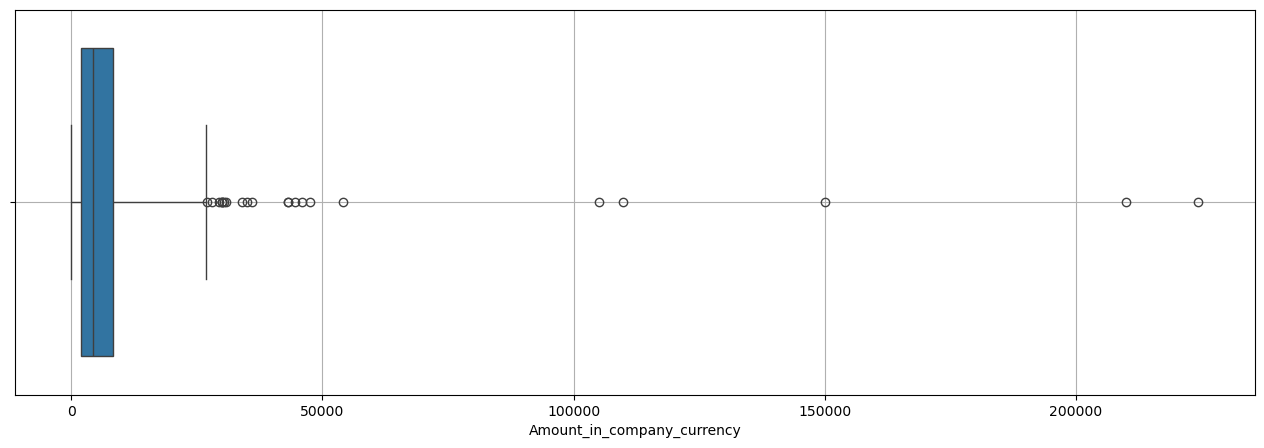

In [16]:
#boxplot, whiskers = 3IQR
plt.figure(figsize = (16,5))
sns.boxplot(x = first_deals.Amount_in_company_currency, whis = 3)

plt.grid()

In [17]:
#check data for deal amounts, it's skewed too
first_deals.int_Related_company_HC.describe()

count      451.00
mean       745.51
std      3,715.68
min          2.00
25%         50.00
50%        170.00
75%        455.00
max     69,778.00
Name: int_Related_company_HC, dtype: float64

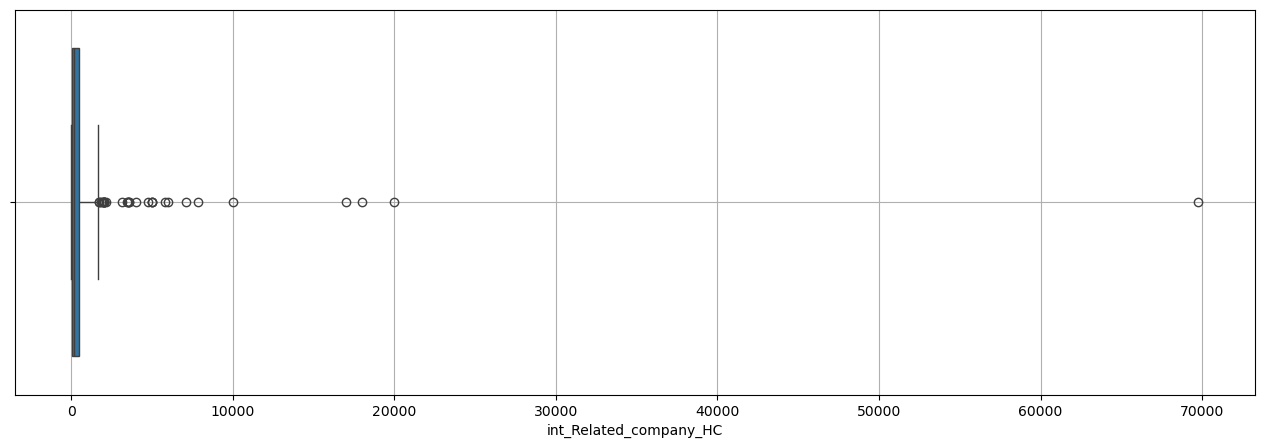

In [18]:
#take a look at boxplot, whiskers = 3IQR
plt.figure(figsize = (16,5))
sns.boxplot(x = first_deals.int_Related_company_HC, whis = 3)

plt.grid()

In [19]:
def CalcUWhisker(series, n):
    return series.quantile(.75) + n * ((series.quantile(.75) - series.quantile(.25)))

#CalcUWhisker(first_deals.Amount_in_company_currency, 3)
#CalcUWhisker(first_deals.int_Related_company_HC, 3)

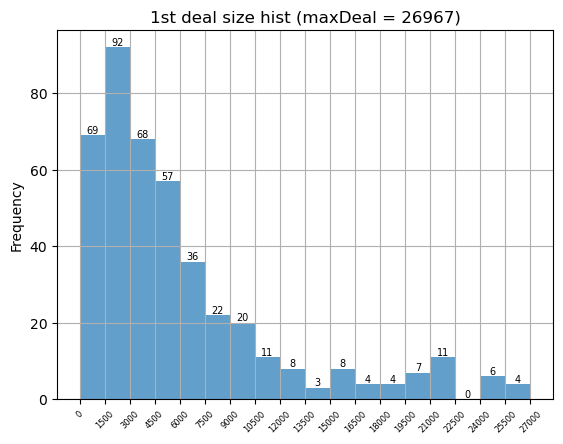

In [20]:
#fastplot 1st deal amounts hist, casting out outliers
maxDeal =  CalcUWhisker(first_deals.Amount_in_company_currency, 3) #+3IQR
#maxDeal = first_deals.Amount_in_company_currency.max()

binz = np.arange(0, maxDeal + 1500, 1500, dtype = np.int64)

ax = first_deals.Amount_in_company_currency.\
                    plot(kind= 'hist', bins=  binz, grid = True, alpha = .7)

plt.title('1st deal size hist (maxDeal = {})'.format(round(maxDeal)))
plt.xticks(binz, fontsize= 6, rotation = 45)
ax.bar_label(ax.containers[0], fontsize= 7);

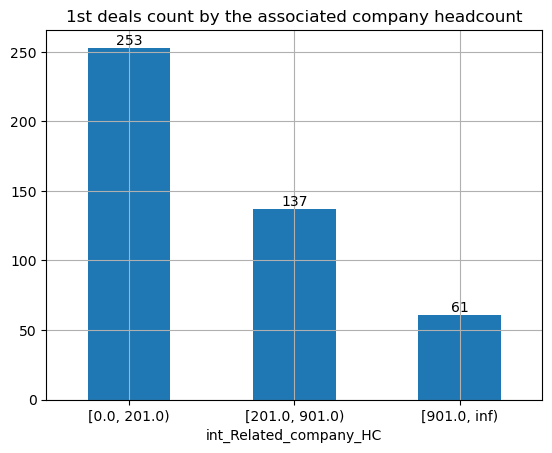

In [21]:
#check N of 1st deals  per Company sizes, work with custom bins  
ax = pd.cut(first_deals.int_Related_company_HC, bins = [0, 201, 901, float('inf')], right = False)\
                        .value_counts()\
                        .plot(kind = 'bar', grid = True)

plt.title('1st deals count by the associated company headcount')
plt.xticks(rotation = 0)
ax.bar_label(ax.containers[0]);

Bins here correspond to the company segmentaion by size (which is measured by headcounts) for 2023

__What about deal created per industry?__

In [22]:
# first_deals.int_Related_company_Industry\
#                         .value_counts(dropna = False)

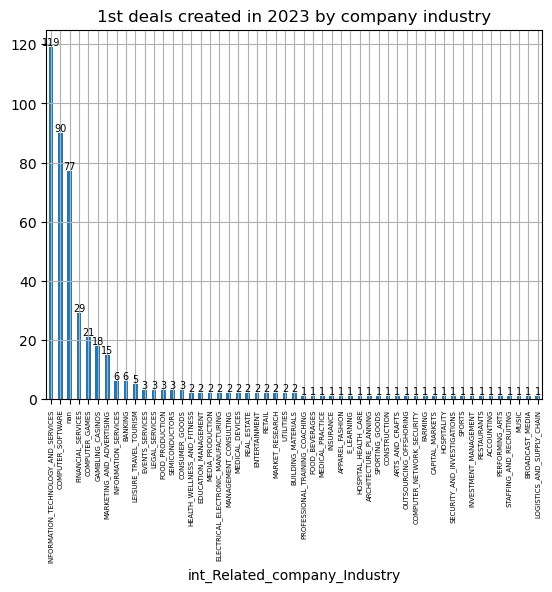

In [23]:
#check company Indusrty distribution for 1st deals as created  
ax = first_deals.int_Related_company_Industry\
                        .value_counts(dropna = False)\
                        .plot(kind = 'bar', grid = True)

plt.title('1st deals created in 2023 by company industry')
plt.xticks(rotation = 90, fontsize = 5)
ax.bar_label(ax.containers[0], fontsize = 7);

In [24]:
# group the Industry and get value_counts and it's percentage of the whole inc NaN which means industry unknown
ind_inc_nan = first_deals.groupby(['int_Related_company_Industry'], dropna = False)\
  .agg( 
        N_values = ('Record_ID', 'count'),
        Percent = ('Record_ID', lambda x: (100 * x.count() / first_deals.shape[0]).round(1))  
      )\
                       .sort_values(['N_values'], ascending = False)
#                       .head(15)

In [25]:
#check the industries that make up close to 80% of the occurrences
idx = np.argmin( np.abs( 80 - np.cumsum(ind_inc_nan.Percent.to_numpy() )))

ind_inc_nan.head(idx + 1)

,N_values,Percent
int_Related_company_Industry,,
INFORMATION_TECHNOLOGY_AND_SERVICES,119,26.40
COMPUTER_SOFTWARE,90,20.00
NaN,77,17.10
FINANCIAL_SERVICES,29,6.40
COMPUTER_GAMES,21,4.70
GAMBLING_CASINOS,18,4.00


__Headcount frequencies and more details for Deal amount vs company HC__

In [26]:
#we assumed that 1st deals are 1-1 with companies, checking headcounts frequencies
first_deals.groupby(['int_Related_company_HC'])\
  .agg( 
        N_values = ('Record_ID', 'count'),
        Percent = ('Record_ID', lambda x: (100* x.count() / first_deals.shape[0]).round(1).astype('str') + '%')  
      )\
                       .sort_values(['N_values'], ascending = False)\
                       .head(15)

,N_values,Percent
int_Related_company_HC,,
50.00,49,10.9%
500.00,22,4.9%
200.00,18,4.0%
10.00,16,3.5%
201.00,13,2.9%
30.00,11,2.4%
"1,000.00",11,2.4%
25.00,8,1.8%
100.00,8,1.8%


As the company headcounts are approximate measures taken from sourcing process for the targeted accounts there are abnormal freaquencies for sharp numbers of like 50, 500, 200 etc 

In [213]:
# cattogries fr deal_source for good sorting
deal_source_ordered = ['Inbound', 'Outbound', 'Field/Offline event', 'Partner referrals', 'Other']

deal_source_categories =  pd.Categorical(first_deals.Deal_source, categories = deal_source_ordered, ordered = True)

type_deal_source_cats = pd.CategoricalDtype(categories = deal_source_ordered, ordered = True)

In [242]:
# deal_source_categories

In [227]:
# define uniform colors for Deal_sources
dsource_colors = {
    'Inbound': '#2a9d8f',
    'Outbound': '#264653',
    'Field/Offline event': '#f4a261',
    'Partner referrals': '#6d597a',
    'Other': '#8d99ae'
}

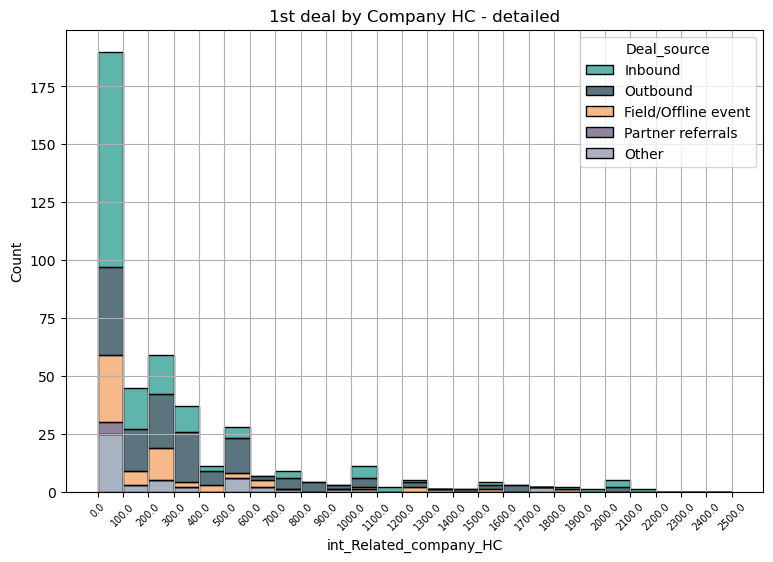

In [241]:
#add more details into N new deals vs company HC chart, color code the deal source
HC_upperbound: int = CalcUWhisker(first_deals.int_Related_company_HC, 5) #2100 #for plot to fit

hc_bins = np.arange(0, HC_upperbound + 100, 100)
#deal_bins1 = np.sort( np.hstack((deal_bins, [210, 510, 1010]))) - adding custom bins

plt.figure(figsize = (9,6))

ax = sns.histplot(
             data = first_deals, 
             x = 'int_Related_company_HC', 
             hue = first_deals.Deal_source.astype(type_deal_source_cats),
             bins= hc_bins,
             palette= dsource_colors,
             # kde = True, 
             multiple = "stack"
            )


ax.set_xticks(deal_bins)
ax.set_xticklabels(ax.get_xticks(), size = 7)
ax.set_xticklabels(ax.get_xticks(), rotation= 45)
ax.set_title('1st deal by Company HC - detailed')
#ax.set_yticks(ticks=10, minor=True)

ax.grid()
plt.show()

In [234]:
first_deals.Deal_source.astype(type_deal_source_cats).value_counts().sort_index()

Deal_source
Inbound                169
Outbound               160
Field/Offline event     66
Partner referrals        5
Other                   51
Name: count, dtype: int64

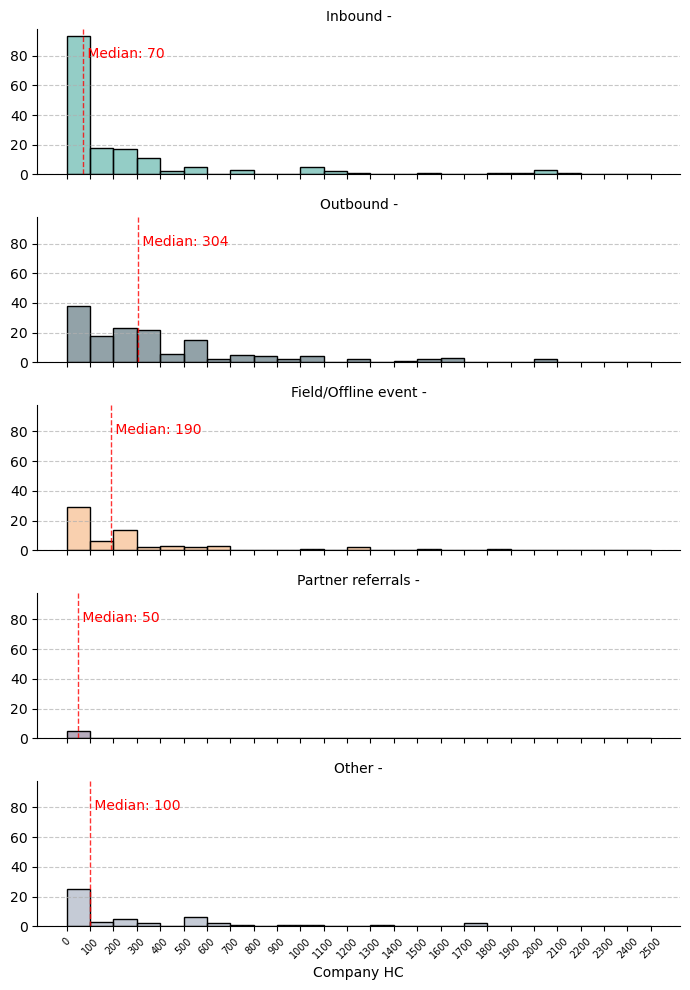

In [231]:
# 5 disrete charts for each of the deal sources
HC_upperbound = CalcUWhisker(first_deals.int_Related_company_HC, 5)
hc_bins = np.arange(0, HC_upperbound + 100, 100)

# We use row="Deal_source" to stack them vertically
g = sns.displot(
    data= first_deals, 
    x='int_Related_company_HC', 
    row= deal_source_categories,     # Creates 5 distinct charts stacked vertically
    #row = first_deals.Deal_source.astype(type_deal_source_cats),
    hue= deal_source_categories,     # Keeps the color coding
    palette= dsource_colors,
    bins= hc_bins,
    height= 2,               # Height of each individual chart
    aspect= 3.5,               # Width-to-height ratio
    facet_kws= {'sharey': True, 'sharex': True}, # Ensures all charts use the same scale
    legend=False
)

def draw_median_line(data, **kwargs):
    median_val = data.int_Related_company_HC.median()
    ax = plt.gca()
    # Draw the vertical line
    ax.axvline(median_val, color='red', linestyle='--', lw=1, alpha=0.8)
    # Add a text label for the numeric median value
    ax.text(median_val, ax.get_ylim()[1] * 0.8, f' Median: {median_val:.0f}', 
            color='red', ha='left')

g.map_dataframe(draw_median_line)

# 3. Refine the axes and labels
g.set_titles("{row_name} -") # Labels each plot with the Deal Source name
g.set_axis_labels("Company HC", "")

# Adjusting ticks for the bottom chart
for ax in g.axes.flat:
    ax.set_xticks(deal_bins)
    ax.tick_params(axis='x', rotation=45, labelsize=7)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Bu far the most deals were brough around by cusotmer sccounts up to 100 employees in size. Inbound and outbound are two major sources for new deals are more or less evenly distributed across the company sizes.

__Take a look and cast out outliers for deal amount and company HC__

In [28]:
#slice data to rid of outliers

#arbitrary values for testing
SubSet_1 = ( first_deals.Amount_in_company_currency < 150000 ) & \
           ( first_deals.int_Related_company_HC < 2000 )

#set outliers out 4% percentiles for deal amounts and company HCs
DealAmount_upper = CalcUWhisker(first_deals.Amount_in_company_currency, 3) #first_deals.Amount_in_company_currency.quantile(0.96)
CoHC_upper = CalcUWhisker(first_deals.int_Related_company_HC, 3) #first_deals.int_Related_company_HC.quantile(0.96)

SubSet_3 = ( first_deals.Amount_in_company_currency <= DealAmount_upper ) & \
           ( first_deals.int_Related_company_HC <= CoHC_upper )

In [206]:
q_96 = 0.96
SubSet_2 = first_deals.eval(
    "Amount_in_company_currency <= Amount_in_company_currency.quantile(@q_96) and "
    "int_Related_company_HC <= int_Related_company_HC.quantile(@q_96)"
)

In [208]:
# SubSet_2

In [29]:
# Deal amount outliers
# first_deals[ first_deals.Amount_in_company_currency > DealAmount_upper  ]\
#              .sort_values(['Amount_in_company_currency'] , ascending = False)

__Explore dependency between deal amount and the associated company HC for each of the deal sources__

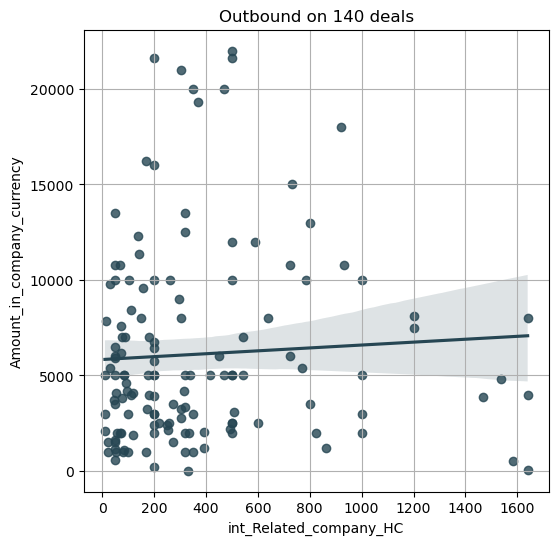

In [243]:
#regplot with trend line for Outbound wo outliers
plt.figure(figsize = (6,6))

Outbound_1stDeals = first_deals[ SubSet_3 & 
                                (first_deals.Deal_source == 'Outbound')
                               ]

ax = sns.regplot(data = Outbound_1stDeals, 
                        y = 'Amount_in_company_currency', 
                        x = 'int_Related_company_HC',
                        scatter = True,
                        color = dsource_colors['Outbound'],
                        #robust=True
                        )
ax.set_title( 'Outbound on {} deals'.format( Outbound_1stDeals.shape[0] ))

plt.grid()

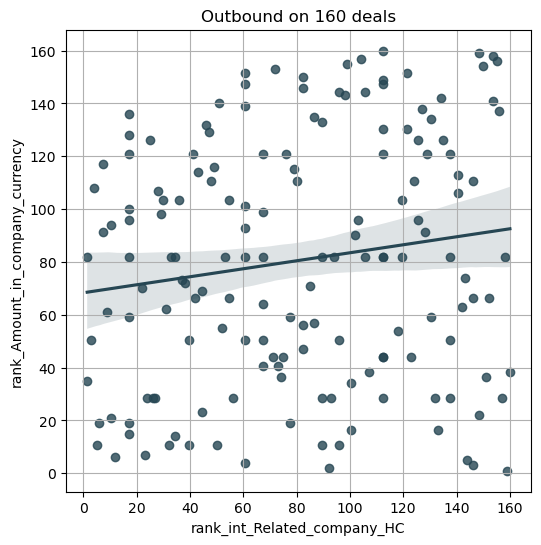

In [246]:
#regplot with trend line for Outbound spearman 
plt.figure(figsize = (6,6))

Outbound_1stDeals = first_deals.query('Deal_source == "Outbound"').copy()

Outbound_1stDeals['rank_Amount_in_company_currency'] = Outbound_1stDeals.Amount_in_company_currency.rank()

Outbound_1stDeals['rank_int_Related_company_HC'] = Outbound_1stDeals.int_Related_company_HC.rank()


ax = sns.regplot(data = Outbound_1stDeals, 
                        y = 'rank_Amount_in_company_currency', 
                        x = 'rank_int_Related_company_HC',
                        scatter = True,
                        color = dsource_colors['Outbound'],
                        #robust=True
                        )
ax.set_title( 'Outbound on {} deals'.format( Outbound_1stDeals.shape[0] ))

plt.grid()

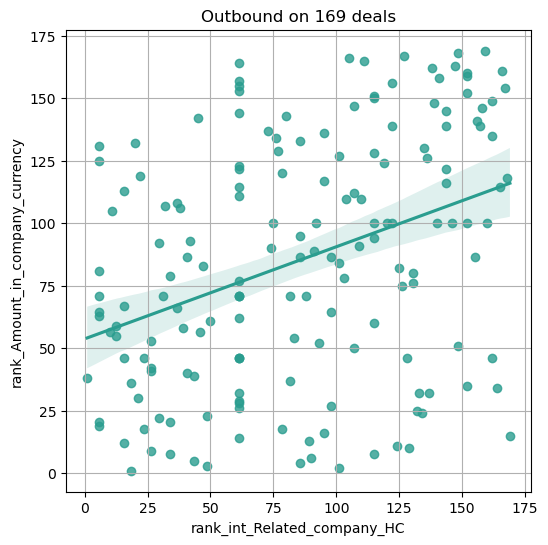

In [247]:
#regplot with trend line for Inbound spearman 
plt.figure(figsize = (6,6))

Outbound_1stDeals = first_deals.query('Deal_source == "Inbound"').copy()

Outbound_1stDeals['rank_Amount_in_company_currency'] = Outbound_1stDeals.Amount_in_company_currency.rank()

Outbound_1stDeals['rank_int_Related_company_HC'] = Outbound_1stDeals.int_Related_company_HC.rank()


ax = sns.regplot(data = Outbound_1stDeals, 
                        y = 'rank_Amount_in_company_currency', 
                        x = 'rank_int_Related_company_HC',
                        scatter = True,
                        color = dsource_colors['Inbound'],
                        #robust=True
                        )
ax.set_title( 'Outbound on {} deals'.format( Outbound_1stDeals.shape[0] ))

plt.grid()

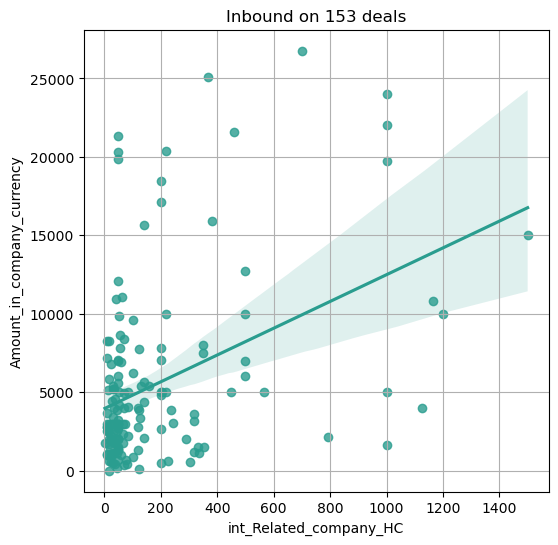

In [248]:
#regplot with trend line for Inbound - wo outliers
plt.figure(figsize = (6,6))

Inbound_1stDeals = first_deals[ SubSet_3 & 
                               (first_deals.Deal_source == 'Inbound') 
                              ]

ax = sns.regplot(data = Inbound_1stDeals, 
              y = 'Amount_in_company_currency', 
              x = 'int_Related_company_HC', 
              scatter = True,
              color = dsource_colors['Inbound'],
             )

ax.set_title( 'Inbound on {} deals'.format( Inbound_1stDeals.shape[0] ))

# plt.xscale('log')
# plt.yscale('log')
plt.grid()

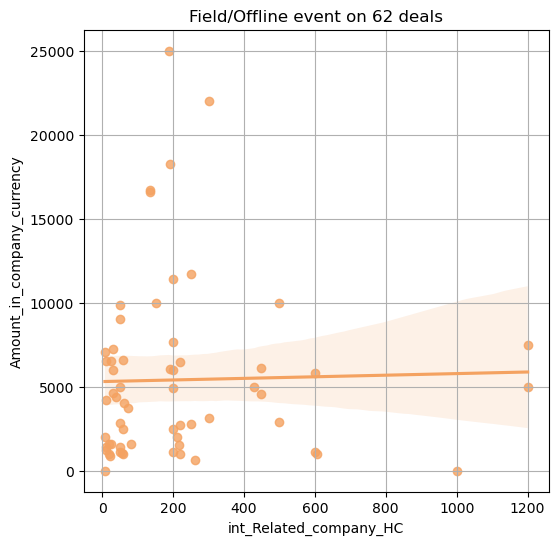

In [249]:
#regplot with trend line for Field - wo Outliers
plt.figure(figsize = (6,6))

Field_1stDeals = first_deals[ SubSet_3 & 
                             (first_deals['Deal_source'] == 'Field/Offline event') 
                            ]

ax = sns.regplot( data = Field_1stDeals, 
                  y = 'Amount_in_company_currency', 
                  x = 'int_Related_company_HC', 
                  scatter = True,
                  color = dsource_colors['Field/Offline event'],
                  ci = 95
                 )

ax.set_title( 'Field/Offline event on {} deals'.format( Field_1stDeals.shape[0] ))

plt.grid()

The slope of the LSRL line in the charts above (LSRL for Least Squared Regression Line) would represent correlation between 1st deal size and the related company size measured as the headcount. The graphs tell us there is some correlation for Inbound and none to even slight negative for Outbound and Field deals. If a larger account comes across the pipeline you could naturally expect a higher probability of getting a bigger sale in this business.

Which posses a good question for further research, i.e. what and at which stage does it wrong with Outbound an Field deal channels? 

__Let us just calculate the correlations coefficients__

In [113]:
from scipy.stats import pearsonr, spearmanr

#format float display
# pd.options.display.float_format = '{:,.3f}'.format

In [163]:
def get_spearman(group):
    rho, p_val = spearmanr(group.iloc[:, 0], group.iloc[:, 1])
    return pd.Series({'spearman rho': rho, 'spearman p_value': p_val, 'count': group.shape[0]})

def get_pearson(group):
    rho, p_val = pearsonr(group.iloc[:, 0], group.iloc[:, 1])
    return pd.Series({'pearson rho': rho, 'pearson p_value': p_val, 'count': group.shape[0]})

In [176]:
# # Correlation is sensitive for outliers, calc Spearman 
# for d_source in first_deals.Deal_source.unique():
#     x = first_deals[ first_deals.Deal_source  == d_source ]['int_Related_company_HC'] 
#     y = first_deals[ first_deals.Deal_source == d_source ]['Amount_in_company_currency']
    
#     count = first_deals[ first_deals.Deal_source == d_source ].shape[0]
    
#     corr, _ = spearmanr(x, y)
#     print(f'Pearson corr All deals: {corr:.3f} for {d_source} deals on {count} deal values')

In [171]:
pearson = (
    first_deals.groupby('Deal_source')
    [['Amount_in_company_currency', 'int_Related_company_HC']]
    .apply(get_pearson)
    .astype({'count':int})
)
pearson

,pearson rho,pearson p_value,count
Deal_source,,,
Field/Offline event,0.350,0.004,66
Inbound,0.089,0.252,169
Other,-0.054,0.705,51
Outbound,-0.008,0.919,160
Partner referrals,-0.057,0.927,5


In [212]:
pearson_wo_outliers = (
    first_deals[ SubSet_3 ]
    .groupby('Deal_source')
    [['Amount_in_company_currency', 'int_Related_company_HC']]
    .apply(get_pearson)
    .astype({'count':int})
)
pearson_wo_outliers

,pearson rho,pearson p_value,count
Deal_source,,,
Field/Offline event,0.024,0.854,62
Inbound,0.415,0.000,153
Other,-0.049,0.751,44
Outbound,0.056,0.509,140
Partner referrals,-0.057,0.927,5


In [175]:
spearman = (
    first_deals.groupby('Deal_source')
    [['Amount_in_company_currency', 'int_Related_company_HC']]
    .apply(get_spearman)
    .astype({'count':int})
)
# spearman.to_clipboard()
spearman

,spearman rho,spearman p_value,count
Deal_source,,,
Field/Offline event,0.151,0.227,66
Inbound,0.368,0.000,169
Other,0.009,0.951,51
Outbound,0.152,0.056,160
Partner referrals,-0.112,0.858,5


In [169]:
# SubSet_3

__Check correlations between 2nd+ total deals and company HC__

In [109]:
#get a slice for existing customer (or 2nd+) deals
secondplus_deals = deals.query( 'Deal_source == "Existing customer" and Create_Date < "2024-01-01"') #[ deals['Deal_source'] == 'Existing customer' ]

In [110]:
#group by Company and sum up deal values
Cos_w_2ndPlusDeals = secondplus_deals.groupby(
                by = 'Ass_Company_ID_1st'
                )\
                .agg(
                    {'Amount_in_company_currency': ['sum', 'count', 'mean'],\
                    'int_Related_company_HC':lambda x: np.unique(x)[0],
                    'Associated_Company':lambda x: str(np.unique(x)[0])}
                    ).reset_index()

#set display options
pd.options.display.float_format = '{:,.0f}'.format

#Cos_w_2ndPlusDeals.sort_values(by = [('Amount_in_company_currency', 'sum')],ascending = False).head(10)

In [111]:
corr, _ = pearsonr(Cos_w_2ndPlusDeals[('Amount_in_company_currency', 'sum')],
                   Cos_w_2ndPlusDeals[('int_Related_company_HC', '<lambda>')])

print(f'Pearson corr Sum of exist customer deals per Co : {corr:.4f} deals on {Cos_w_2ndPlusDeals.shape[0]} companies')

Pearson corr Sum of exist customer deals per Co : 0.2054 deals on 163 companies


There is a small positive correlation between total amount of repeted deals (i.e. repetead revenue) per customer and it's account size. It is expected and at same time the question how we can increase it.

__Explore deals closed in 2023__ 

In [112]:
#get slice for the deals closed in 2023 
closed_deals = deals[ deals.Deal_Stage.isin(['Closed won', 'Closed lost']) &\
                                         (deals.Close_Date < pd.to_datetime('2024-01-01')) ]

In [113]:
#closed_deals.info()
closed_deals.shape

(706, 12)

In [134]:
#1st and repeted deals apart
closed_deals_1st = closed_deals.query('Deal_source != "Existing customer" and Pipeline != "Customer Success"')

closed_deals_2ndPlus = closed_deals.query('Deal_source == "Existing customer"')

In [115]:
#closed_deals_1st.shape

#closed_deals_2ndPlus.shape

__Winrates breakdown by deal source and Company HC__

In [136]:
#define winrate functions
funcN = lambda x: (x == 'Closed won').sum()/x.count() # calc winrate for N of deals
funcSum = lambda x: x[ closed_deals.Deal_Stage == 'Closed won' ].sum()/x.sum() #winrate for deal amount
funcMeanWon = lambda x: x[ closed_deals.Deal_Stage == 'Closed won' ].mean()

In [137]:
#Winrates by the deal source
cl_deals_gr3 = closed_deals.groupby(by = [ 'Deal_source'])\
                                .agg( Winrate_N = ('Deal_Stage', funcN ),
                                      Winrate_Sum = ('Amount_in_company_currency', funcSum ),
                                      N_values = ('Deal_Stage', 'count' ),
                                      Av_deal_cl = ('Amount_in_company_currency', 'mean' ),
                                      Av_deal_Won = ('Amount_in_company_currency', funcMeanWon )
                                     )\
                                .reset_index()


cl_deals_gr3.N_values.astype(int)

#proper display w heatmap stile formatting
cm = sns.light_palette("green", as_cmap = True)

cl_deals_gr3.style.format('{:.2f}', subset = ['Winrate_N','Winrate_Sum'])\
                   .format('{:.0f}', subset = ['Av_deal_cl', 'Av_deal_Won'])\
                   .background_gradient(cm, subset = ['Winrate_N','Winrate_Sum'])
#cl_deals_gr1

,Deal_source,Winrate_N,Winrate_Sum,N_values,Av_deal_cl,Av_deal_Won
0,Existing customer,0.68,0.66,352,9697,9417
1,Field/Offline event,0.50,0.55,50,7095,7776
2,Inbound,0.40,0.60,142,7606,11301
3,Other,0.37,0.55,41,15935,23962
4,Outbound,0.24,0.27,117,10137,11387
5,Partner referrals,0.50,0.55,4,3038,3325


It is to no surprise that:
- the repeated deals have better winrates overall compared to the 1st deals
- inbound deals have roughly x2 winrates as oubount

In [138]:
#breakdown 1st deal winrates between company sizes

cl_deals_gr1 = closed_deals_1st.groupby(by = [ #'Deal_source',\
                             pd.cut( closed_deals.int_Related_company_HC, [0, 201, 901, float("inf")], right = False ) 
                                     ])\
                                .agg( Winrate_N = ('Deal_Stage', funcN ),
                                      Winrate_Sum = ('Amount_in_company_currency', funcSum ),
                                      N_deals_closed = ('Deal_Stage', 'count' ),
                                      Av_deal_closed = ('Amount_in_company_currency', 'mean' ),
                                      Av_deal_Won = ('Amount_in_company_currency', funcMeanWon )
                                     )\
                                .reset_index()


#cl_deals_gr1.N_values.astype(int)

#proper display w heatmap stile formatting
cm = sns.light_palette("green", as_cmap = True)

cl_deals_gr1.style.format('{:.2f}', subset = ['Winrate_N','Winrate_Sum'])\
                   .format('{:.0f}', subset = ['Av_deal_closed', 'Av_deal_Won'])\
                   .background_gradient(cm, subset = ['Winrate_N','Winrate_Sum'])

#cl_deals_gr1.to_clipboard()

,int_Related_company_HC,Winrate_N,Winrate_Sum,N_deals_closed,Av_deal_closed,Av_deal_Won
0,"[0.0, 201.0)",0.43,0.54,201,5854,7319
1,"[201.0, 901.0)",0.30,0.38,103,12609,16048
2,"[901.0, inf)",0.18,0.48,50,16216,43252


Notably enough the win rates for the numebr of deals decrease with customer size. However the win rate based on the deal amopunt exceeds same for deal numbers for [901, inf) interval meaning that the bigger deals for this cusotmer segment close well compared to the smaller ones

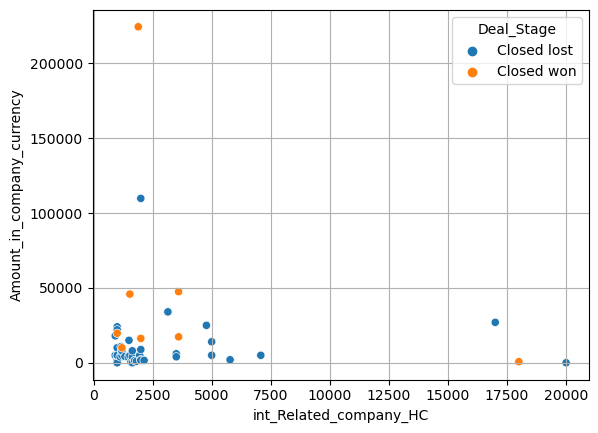

In [125]:
#fast draw the deal situation for [901, inf) in scatter plot
sns.scatterplot( data = closed_deals_1st[ closed_deals_1st.int_Related_company_HC > 900 ] , 
                  y = 'Amount_in_company_currency', 
                  x = 'int_Related_company_HC', 
                  hue = 'Deal_Stage'
                 )
plt.grid()

Won deals in the segment [901, inf) are fewer in numbers but have high amounts, there are suspected outliers as for the deal amount

In [280]:
#get basic stats for Close rates per indusrty

cl_deals_gr4 = closed_deals_1st.groupby([ 'int_Related_company_Industry',\
                          #pd.cut( closed_deals.int_Related_company_HC, [0, 201, float("inf")], right = False ) 
                          ], dropna=False)\
                                .agg( Winrate_N = ('Deal_Stage', funcN ),
                                      Winrate_Sum = ('Amount_in_company_currency', funcSum ),
                                      N_deals_closed = ('Deal_Stage', 'count' ),
                                      Av_deal_closed = ('Amount_in_company_currency', 'mean' ),
                                      Av_deal_Won = ('Amount_in_company_currency', funcMeanWon )
                                     )\
                                .sort_values(['N_deals_closed'], ascending = False)\
                                .reset_index()


#cl_deals_gr1.N_values.astype(int)

cm = sns.light_palette("green", as_cmap = True)

cl_deals_gr4.head(10).style.format('{:.2f}', subset = ['Winrate_N','Winrate_Sum'])\
                   .format('{:.0f}', subset = ['Av_deal_closed', 'Av_deal_Won'])\
                   .background_gradient(cm, subset = ['Winrate_N','Winrate_Sum'])\

#cl_deals_gr4.to_clipboard()

,int_Related_company_Industry,Winrate_N,Winrate_Sum,N_deals_closed,Av_deal_closed,Av_deal_Won
0,INFORMATION_TECHNOLOGY_AND_SERVICES,0.38,0.37,97,8030,7841
1,COMPUTER_SOFTWARE,0.28,0.62,72,14178,31854
2,nan,0.50,0.42,62,11710,9886
3,FINANCIAL_SERVICES,0.18,0.11,22,5904,3726
4,COMPUTER_GAMES,0.40,0.42,20,7222,7516
5,GAMBLING_CASINOS,0.27,0.48,15,6637,11925
6,MARKETING_AND_ADVERTISING,0.31,0.55,13,4203,7474
7,BANKING,0.40,0.10,5,13943,3542
8,INFORMATION_SERVICES,0.20,0.63,5,5428,17088
9,LEISURE_TRAVEL_TOURISM,0.50,0.46,4,2833,2612


__Key takeaways:__

- We can see the expected positive correlation between 1st deal size and the related customer account size for Inbound but not for Outbound and Field lead channells. That propmpts the leadgen and account exec process check-up to identify and address its bottlenecks.
- There are sizable inconsistenciy in data violating the proper relationship between 1st deals and the customer account (should be 1st deal 1/0 - 1 company) due to manual data entry and missing validaiton. We have to rectify the the data either manually or porgrammatically and chekc that key metrics hold. 